# Report

- I implemented a recursive buildDecisionTree method that is very similar to the one in the book Artificial Intelligence, A Modern Approach.
- Its inputs are, subset of the data to be splitted, original_whole_data, method to calculate importance, and minimum purity to stop splitting
- There were 4 cases defined in the book but there are 5 here since we have minimum Purity criteria to stop splitting
    - 1- If the remaining examples have all the same target variable, return it
    - 2- If there's no remaining examples, return the plurality class of WHOLE_SET
    - 3- If there are some positive and negative examples, but purity is below minimum Purity threshold, don't split further, and return the plurality of the subset 
    - 4- If there's no attribute left, return the plurality of the target variable in the remaining examples
    - 5- If there are some positive and negative examples but purity is not below the minimumPurity threshold, create the subtree recursively using the subset_of_values_in_node data
- The output of buildDecisionTree method is a list so tree is visualized by printing this list in recursive way. Since buildDecisionTree is a recursive method, output of the method is list of lists of lists of lists... being nested lists. First element of each list is node and other two elements are unique value and classification, unless there is a split which results in another nested list in recursive way.
- In order to be able to visualize the generated tree properly, I implemented a Recursive_Print function which does so.
- I implemented helper gini and entropy functions to use in buildDecisionTree
- To be able to manage minimum Purity metric for both entropy and gini, I normalized the Gini value, by subtracting gini from 0.5 since (0, 0.5) is the range of it, and normalized it, dividing by 0.5, similar to Information Gain calculation. So that its new range changed to (0, 1.0)

$$Normalized Gini = \frac{(0.5 - Gini)}{0.5} $$

- I tried various minimumPurity values for both 'entropy' and 'gini' and reported, commented the results below the printed trees in the Code section. 
- Code is heavily commented as it was requested

- The dataset used to build Tree is the famous Titanic dataset with both numeric and categorical attributes.
- I encoded the numeric attributes by finding split points, binning them

# Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
epsilon = 1e-10 # to prevent 0 divisions

- Titanic Dataset
- Attributes are the information of the passengers such as age, name, number of siblings, number of parent and children, ticket, price of ticket, cabin, the port they embarked from
- Target attribute is 'Survived', whether they survived the disaster or not
- The idea is to predict whether a passenger with specific demographics would survive if he/she had been in the Titanic back then

In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

- Convert Age numeric attribute to Categorical
- Due to "Children and Women First!" policy, whether a person would survive depends on whether he/she's a child or not, rather than numeric age
- Therefore I categorize the age below and above 18

In [5]:
lst_age = []
for age in df['Age'].values:
    if age == np.nan:
        lst_age.append('Adult') # Since majority is adult, I will fill NaN values with majority
    elif age < 18:
        lst_age.append('Child')
    else:
        lst_age.append('Adult')
df['Age'] = lst_age

- Create Family_Size attribute by summing Parent_Children and Siblings_Spouses attributes
- Convert it to has_Family binary variable
- The idea is, one's likelihood to survive might increase in such an environment where family support can increase the likelihood of surviving of other members

In [6]:
df['has_Family'] = df['Parch'] + df['SibSp']
lst_hasFamily= []
for familysize in df['has_Family'].values:
    if familysize < 1:
        lst_hasFamily.append('Alone')
    else:
        lst_hasFamily.append('Not_Alone')
df['has_Family'] = lst_hasFamily

- In early 20th century still aristochratic Britain, titles are very important and there are many of them
- To simplify it, they are categorized into 'Noble' and 'Not_Noble'
- Since rich/nobility have higher chance of surviving, this shall be an important attribute

In [7]:
# Create Title attribute by extracting it from the Name attribute
df['Title'] = df.Name.str.extract('([A-Za-z]+)\.')

# Dictionary for replacement
di = {'Dona': 'Noble',
      'Lady': 'Noble',
      'Mr' : 'Not_Noble',
      'Mrs' : 'Not_Noble',
      'Miss': 'Not_Noble',
      'Mme': 'Not_Noble',
      'Ms': 'Not_Noble',
      'Col': 'Not_Noble',
      'Mlle': 'Not_Noble',
      'Lady': 'Noble',
      'the Countess': 'Noble',
      'Don': 'Noble',
      'Major': 'Not_Noble',
      'Capt': 'Not_Noble',
      'Jonkheer': 'Noble',
      'Dr': 'Not_Noble',
      'Rev' : 'Not_Noble',
      'Master': 'Noble',
      'Sir': 'Noble',
      'Countess': 'Noble'}
# Replace it according to Dict
df['is_Noble'] = df['Title'].replace(di)

- Handling 'Fare', the ticket price attribute:

<AxesSubplot:title={'center':'Distribution of Fare by Survived'}, ylabel='Density'>

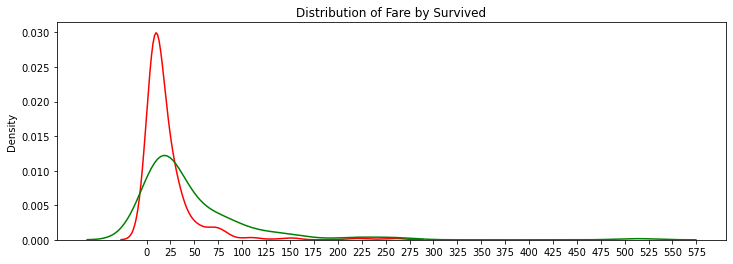

In [8]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_xticks(range(0, 600, 25))
ax.set_title('Distribution of Fare by Survived')
sns.kdeplot(df['Fare'][df['Survived'] == 0].values, color = 'red', label = 'Dead')
sns.kdeplot(df['Fare'][df['Survived'] == 1].values, color = 'green', label = 'Survived')

(0.0, 0.01)

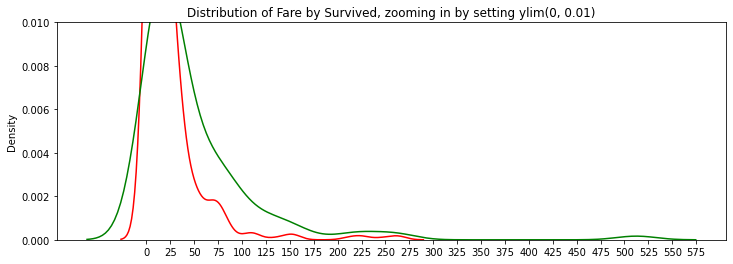

In [9]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_xticks(range(0, 600, 25))
ax.set_title('Distribution of Fare by Survived, zooming in by setting ylim(0, 0.01)')
sns.kdeplot(df['Fare'][df['Survived'] == 0].values, color = 'red', label = 'Dead')
sns.kdeplot(df['Fare'][df['Survived'] == 1].values, color = 'green', label = 'Survived')
ax.set_ylim((0, 0.01)) # Setting ylim to see the smaller values better

- It seems there are far more death ratio in lower Fare.
- In order to keep it relatively simple, I will simply bin them by splitting the continuous 'Fare' by inspecting the figures above.
- There's a some kind of intersection for both groups around 25 and 175.
- And in 275, red ones end and tickets with 'Fare' above 275 all seems to have survived.
- So these will be my splitting points

In [10]:
lst_fare = []
for fare in df['Fare'].values:
    if fare < 25:
        lst_fare.append('0-25')
    elif (fare >= 25) & (fare < 150):
        lst_fare.append('25-150')
    elif (fare >= 150) & (fare < 275):
        lst_fare.append('150-275')
    else:
        lst_fare.append('275-550')
df['Fare'] = lst_fare
print(df['Fare'].unique())

['0-25' '25-150' '150-275' '275-550']


- OK now I have categorical Fare values

- Replace 0-1 values with Dead/Survived strings and drop non desired attributes
- It should be noted that 'Survived' is the last columnn of the dataframe since methods of DecisionTree is created so that they always take the last column as the target variable

In [11]:
df['Survived'] = df['Survived'].astype(str).str.replace('0', 'Dead').str.replace('1', 'Survived')
df = df[['Pclass', 'Age', 'Sex', 'Embarked', 'has_Family', 'is_Noble', 'Fare', 'Survived']].astype(str)

In [12]:
for column in df.columns:
    print(df[column].unique())

['3' '1' '2']
['Adult' 'Child']
['male' 'female']
['S' 'C' 'Q' 'nan']
['Not_Alone' 'Alone']
['Not_Noble' 'Noble']
['0-25' '25-150' '150-275' '275-550']
['Dead' 'Survived']


In [13]:
df[df['Embarked'] == 'nan']

,Pclass,Age,Sex,Embarked,has_Family,is_Noble,Fare,Survived
61,1,Adult,female,nan,Alone,Not_Noble,25-150,Survived
829,1,Adult,female,nan,Alone,Not_Noble,25-150,Survived


- There is a 'nan' value Embarked column, when inspected, there are 2 of them.
- I will replace these with the majority of Embarked

In [14]:
df['Embarked'].loc[df['Embarked'] == 'nan'] = df['Embarked'].value_counts().idxmax()

- Finally dataset is ready for training

In [15]:
print('The data looks like:')
df.head()

The data looks like:


,Pclass,Age,Sex,Embarked,has_Family,is_Noble,Fare,Survived
0,3,Adult,male,S,Not_Alone,Not_Noble,0-25,Dead
1,1,Adult,female,C,Not_Alone,Not_Noble,25-150,Survived
2,3,Adult,female,S,Alone,Not_Noble,0-25,Survived
3,1,Adult,female,S,Not_Alone,Not_Noble,25-150,Survived
4,3,Adult,male,S,Alone,Not_Noble,0-25,Dead


- PassengerClass attribute is converted to string, even though it seems numeric

- Method to calculate Entropy for all the dataset since calculating Entropy involves
    - calculating Entropy for all Dataset
    - calculating Entropy for each attribute

In [16]:
def entropy_of_dataset(df): 
    entropy = 0 
    target_variable = df.columns.values[-1]
    
    # for every unique instance in target variable, calculate their fraction and add it to entropy
    for value in df[target_variable].unique(): 
        frac = df[target_variable].value_counts()[value] / df[target_variable].shape[0]
        entropy += -frac * np.log2(frac)
    return entropy

In [17]:
entropy_of_dataset(df)

0.9607079018756469

- Calculate Entropy for all attributes in the dataset

In [18]:
def entropy(df):
    
    lst_entropy = []
    target_variable = df.columns.values[-1]
    
    # for every attribute in df calculate attribute
    for attribute in df.columns.values[:-1]:
        values_in_attribute  = df[attribute].unique()    # Unique values in attribute
        values_in_target_variable = df[target_variable].unique() # Unique values in target_variable

        entropy_of_attribute = 0
        
        # starting with calculating for every unique value in attribute
        for variable in values_in_attribute:
            entropy_of_each_unique_value = 0 # Entropy of the unique value of the attribute

            for label in values_in_target_variable:
                num = df[attribute][df[attribute] == variable][df[target_variable] == label].shape[0]
                den = df[attribute][df[attribute] == variable].shape[0]
                
                # calculate the ratio by dividing numerator by denumerator
                frac = num / (den + epsilon) # epsilon protects from 0 divison
                
                # Entropy for single unique value in the attribute
                entropy_of_each_unique_value += -frac * np.log2(frac + epsilon)  # epsilon protects from 0 divison

            frac2 = den / df.shape[0]
            entropy_of_attribute += -frac2 * entropy_of_each_unique_value 

        lst_entropy.append(abs(entropy_of_attribute))
    df_entropy = pd.DataFrame(lst_entropy).T
    df_entropy.columns = df.columns.values[:-1]
    return df_entropy

In [19]:
entropy(df)

,Pclass,Age,Sex,Embarked,has_Family,is_Noble,Fare
0,0.876877,0.950225,0.743048,0.940174,0.930999,0.95481,0.909346


- Information Gain = Entropy of the Dataset - Entropy of Attribute (for each attribute)
- Calculate Information Gain for all attributes using entropy()

In [20]:
def information_gain(df):
    df_information_gain = (df.shape[1]-1) * [entropy_of_dataset(df)] - entropy(df)
    return df_information_gain

In [21]:
information_gain(df)

,Pclass,Age,Sex,Embarked,has_Family,is_Noble,Fare
0,0.083831,0.010483,0.21766,0.020534,0.029709,0.005898,0.051362


- Method to calculate Gini_Index for the given dataset

In [22]:
def gini(df):
    lst_gini = []
    
    # For every attribute
    for column in df.columns.values[:-1]: 
        
        # List of unique values in that attribute
        unique_values_in_attribute = df[column].unique() 
        
        # List of gini index values for columns
        lst_g = []
        
        # List of number of instances in unique_value of attribute
        lst_probs_total_counts = [] 
        
        # For every unique_value in that attribute
        for unique_value in unique_values_in_attribute: 
            
            # Probabilities
            probs = df[df[column] == unique_value][df.columns.values[-1]].value_counts(normalize = True).values
            
            # Number of instance for that unique_value
            total_count_in_prob = np.sum(df[df[column] == unique_value][df.columns.values[-1]].value_counts().values) 
            lst_probs_total_counts.append(total_count_in_prob)
            g = 1
            for prob in probs:
                g-= prob**2
            lst_g.append(g)
            
        # Weighted sum of unique_attributes for final gini index value of the attribute
        gini_of_attribute = np.dot(np.array(lst_probs_total_counts) / df.shape[0], lst_g) 
        lst_gini.append(gini_of_attribute)
        
    df2 = pd.DataFrame(lst_gini).T
    df2.columns = df.columns.values[:-1]
    return df2

- Now inspect entropy, gini and information_gain values for Titanic Dataset

In [23]:
entropy(df)

,Pclass,Age,Sex,Embarked,has_Family,is_Noble,Fare
0,0.876877,0.950225,0.743048,0.940174,0.930999,0.95481,0.909346


In [24]:
information_gain(df)

,Pclass,Age,Sex,Embarked,has_Family,is_Noble,Fare
0,0.083831,0.010483,0.21766,0.020534,0.029709,0.005898,0.051362


In [25]:
gini(df)

,Pclass,Age,Sex,Embarked,has_Family,is_Noble,Fare
0,0.418391,0.465945,0.333365,0.459229,0.45345,0.469012,0.439682


- Gini ranges between (0, 0.5) while entropy ranges between (0, 1)
- Also, when we use entropy, we actually use the Information Gain, subtracting entropy from 1 so that, it indicates higher information/importance/purity for the attribute
- In order to normalize Gini to adapt to this kind of approach, I somewhat standardized Gini:
$$ Normalized_Gini = \frac{(0.5 - Gini)}{0.5} $$
- This way, it will be possible to use the same minimumPurity stopping criteria for both 'gini' and 'entropy'.

In [26]:
(0.5 - gini(df)) / 0.5

,Pclass,Age,Sex,Embarked,has_Family,is_Noble,Fare
0,0.163217,0.06811,0.33327,0.081542,0.0931,0.061977,0.120637


In [27]:
information_gain(df)

,Pclass,Age,Sex,Embarked,has_Family,is_Noble,Fare
0,0.083831,0.010483,0.21766,0.020534,0.029709,0.005898,0.051362


- Pearson's Linear Correlationfor Information_Gain & Normalized_Gini

In [28]:
np.corrcoef([np.reshape(information_gain(df).values, df.shape[1]-1), np.reshape(((0.5 - gini(df)) / 0.5).values, df.shape[1]-1)])[0][1]

0.9999867181357643

- As seen above, both metrics are more similar compared to before, having very high linear correlation now, higher value indicating higher importance this way

- next_attribute_to_split() method returns the attribute with highest purity in the given dataset, according to given method, whether 'entropy', or 'gini'
- Standardization of purity value for 'gini' is done here

In [29]:
def next_attribute_to_split(df, method = 'entropy'): 
    # Returns the attribute with highest information gain in df, as well as its value
    if method == 'entropy': 
        return information_gain(df).T.idxmax().values[0], information_gain(df).T.max().values[0]
    
    # Returns the attribute with the minimum gini index in df, as well as its value
    else: 
        return ((0.5 - gini(df)) / 0.5).T.idxmax().values[0], ((0.5 - gini(df)) / 0.5).T.max().values[0]

In [30]:
print(next_attribute_to_split(df, 'entropy'))
print(next_attribute_to_split(df, 'gini'))

('Sex', 0.2176601069490003)
('Sex', 0.3332699992228191)


- buildDecisionTree() is the recursive method that creates the tree
- Its inputs are data to build tree upon, minimumPurity value to stop and method to calculate the purity/split the tree
- It returns a set objects, which contains attributes as keys, and outcome as values.
- In case there's a split for the attribute, then value of the key is another set, which is the result of recursion

In [31]:
def buildDecisionTree(subset, wholeset, tree = None, minimumPurity = 0.2, method = 'entropy'): 

    # subset is the subset given to split further.
    # wholeset is the whole data set
    # tree is the empty set to build tree upon
    # minimumPurity is the Purity value to stop splitting furthermore
    # method is the method to calculate purity. Can be 'entropy' or 'gini'
    
    # target_variable is always the last column in the data
    target_variable = df.columns.values[-1]
    
    node, purity = next_attribute_to_split(subset, method = method)
    unique_values_in_node = wholeset[node].unique()
    
    if tree is None:                    
        tree = []
        tree.append(node)

    # for every unique value in the node, subset of the original data 
    for unique_value_of_attribute in unique_values_in_node:

        subset_of_values_in_node = subset[subset[node] == unique_value_of_attribute].reset_index(drop=True)
        number_of_classes_in_subset = subset_of_values_in_node[target_variable].nunique()
        unique_values_in_subset = sorted(subset_of_values_in_node[target_variable].unique())


        # 1- If the remaining examples have all the same target variable, return it
        if number_of_classes_in_subset == 1:
            tree.append([node, unique_value_of_attribute, unique_values_in_subset[0]])
            #tree[node][unique_value_of_attribute] = unique_values_in_subset[0]

        
        # 2- If there's no remaining examples, return the plurality class of WHOLE_SET
        elif (subset_of_values_in_node.shape[0] == 0):
            tree.append([node, unique_value_of_attribute, wholeset[target_variable].value_counts().idxmax()])
            #tree[node][unique_value_of_attribute] = wholeset[target_variable].value_counts().idxmax()
            
        # 3- If there's no attributes left, return the plurality of remaining samples
        elif (subset_of_values_in_node.shape[1] == 2):
            tree.append([node, unique_value_of_attribute, subset_of_values_in_node[target_variable].value_counts().idxmax()])
            #tree[node][unique_value_of_attribute] = subset_of_values_in_node[target_variable].value_counts().idxmax()
            
        # 4- If there are some positive and negative examples but,
        #    purity is below minimum Purity threshold, don't split further, and return the plurality of the subset    
        elif ((method == 'entropy') & (purity < minimumPurity)) | ((method == 'gini') & (purity < minimumPurity)):
            tree.append([node, unique_value_of_attribute, subset_of_values_in_node[target_variable].value_counts().idxmax()])
            #tree[node][unique_value_of_attribute] = subset_of_values_in_node[target_variable].value_counts().idxmax()
           
            
        # 5- If there are some positive and negative examples but,
        #    purity is not below the minimumPurity threshold,
        #    create the subtree recursively using the subset_of_values_in_node data,
        #    dropping the current attribute/node, otherwise it may result in infinite loop
        else:
            tree.append([node, unique_value_of_attribute, buildDecisionTree(subset = subset_of_values_in_node.drop(node, axis = 1), wholeset = wholeset, tree = None, minimumPurity = minimumPurity, method = method)])
            #tree[node][unique_value_of_attribute] = buildDecisionTree(subset = subset_of_values_in_node.drop(node, axis = 1), wholeset = wholeset, tree = None, minimumPurity = minimumPurity, method = method) #Calling the function recursively 
    

    # if all children of a node has same return value, make it a leaf with that value, handling duplicate leafs
    lst_to_check_duplicates = tree[1:]
    value = lst_to_check_duplicates[0][2]
    values_in_lst_to_check_duplicates = []
    for i in range(len(lst_to_check_duplicates)):
        values_in_lst_to_check_duplicates.append(lst_to_check_duplicates[i][2])
    
    if all(x == values_in_lst_to_check_duplicates[0] for x in values_in_lst_to_check_duplicates):
        tree = value
        
    return tree

- Recursive_Print methods prints the created tree in recursive calls, in order to enable visual inspection

In [32]:
def recursive_print(t, depth = 0):
    for i, item in enumerate(t):
        
        # Seperate different levels of tree with dash, according to depth of the tree
        if i == 0:
            print(depth*6*"-")
            
        # If the element is string, print it, if it's another nested list, call the function recursively.
        if isinstance(item, str):
            print(depth*"     " + item)
        else:
            recursive_print(item, depth = depth + 1)

- Testing DecisionTree method with various minimumPurity values for both methods:

In [33]:
minimumPurity = 0.5
methods = ['entropy', 'gini']
print('Minimum Purity criteria to stop splitting: ' + str(minimumPurity))
for i, method in enumerate(methods):
    print('Method: ' + method)
    print('Tree built looks like: ')
    t = buildDecisionTree(subset = df, wholeset = df, minimumPurity = minimumPurity, method = method)
    recursive_print(t, depth = 0)
    if i == 0:
        print(5*"\n")

Minimum Purity criteria to stop splitting: 0.5
Method: entropy
Tree built looks like: 

Sex
------
     Sex
     male
     Dead
------
     Sex
     female
     Survived






Method: gini
Tree built looks like: 

Sex
------
     Sex
     male
     Dead
------
     Sex
     female
     Survived


In [34]:
minimumPurity = 0.2
methods = ['entropy', 'gini']
print('Minimum Purity criteria to stop splitting: ' + str(minimumPurity))
for i, method in enumerate(methods):
    print('Method: ' + method)
    print('Tree built looks like: ')
    t = buildDecisionTree(subset = df, wholeset = df, minimumPurity = minimumPurity, method = method)
    recursive_print(t, depth = 0)
    if i == 0:
        print(5*"\n")

Minimum Purity criteria to stop splitting: 0.2
Method: entropy
Tree built looks like: 

Sex
------
     Sex
     male
------------
          Fare
------------------
               Fare
               0-25
               Dead
------------------
               Fare
               25-150
               Dead
------------------
               Fare
               150-275
               Dead
------------------
               Fare
               275-550
               Survived
------
     Sex
     female
------------
          Pclass
------------------
               Pclass
               3
------------------------
                    Fare
------------------------------
                         Fare
                         0-25
                         Survived
------------------------------
                         Fare
                         25-150
                         Dead
------------------------------
                         Fare
                         150-275
                  

In [35]:
minimumPurity = 0.1
methods = ['entropy', 'gini']
print('Minimum Purity criteria to stop splitting: ' + str(minimumPurity))
for i, method in enumerate(methods):
    print('Method: ' + method)
    print('Tree built looks like: ')
    t = buildDecisionTree(subset = df, wholeset = df, minimumPurity = minimumPurity, method = method)
    recursive_print(t, depth = 0)
    if i == 0:
        print(5*"\n")

Minimum Purity criteria to stop splitting: 0.1
Method: entropy
Tree built looks like: 

Sex
------
     Sex
     male
------------
          Fare
------------------
               Fare
               0-25
               Dead
------------------
               Fare
               25-150
               Dead
------------------
               Fare
               150-275
               Dead
------------------
               Fare
               275-550
               Survived
------
     Sex
     female
------------
          Pclass
------------------
               Pclass
               3
------------------------
                    Fare
------------------------------
                         Fare
                         0-25
------------------------------------
                              Embarked
------------------------------------------
                                   Embarked
                                   S
                                   Dead
-----------------------------

In [36]:
minimumPurity = 0
methods = ['entropy', 'gini']
print('Minimum Purity criteria to stop splitting: ' + str(minimumPurity))
for i, method in enumerate(methods):
    print('Method: ' + method)
    print('Tree built looks like: ')
    t = buildDecisionTree(subset = df, wholeset = df, minimumPurity = minimumPurity, method = method)
    recursive_print(t, depth = 0)
    if i == 0:
        print(5*"\n")

Minimum Purity criteria to stop splitting: 0
Method: entropy
Tree built looks like: 

Sex
------
     Sex
     male
------------
          Fare
------------------
               Fare
               0-25
------------------------
                    is_Noble
------------------------------
                         is_Noble
                         Not_Noble
                         Dead
------------------------------
                         is_Noble
                         Noble
------------------------------------
                              Pclass
------------------------------------------
                                   Pclass
                                   3
------------------------------------------------
                                        Embarked
------------------------------------------------------
                                             Embarked
                                             S
------------------------------------------------------------
      

- As expected, as purity value decreased, the tree grew deeper and larger.
- When trees created are inspected, it is trivial to see the 'Sex' or gender is the most important one due "Children and Women First!" policy.
- Despite that, being noble had higher impact than being child or adult.
- It is also observed that if a male is to survive, and he is not from nobility, he better be a child or have paid a high amount of Fare!
- Passenger Class also seems to be important, as it is correlated with wealth/nobility
- Other attributes such as the port embarked and having family are relatively less important
- Despite the normalization efforts to Gini, trees produced by two methods ended up in different depth for some minimumPurity values, however it was still useful since it allowed the use of single minimumPurity parameter.
- In the end both methods produced very similar, consistent trees, 'Sex', 'is_Noble', 'Fare' having high impact, being closer to root. 